In [1]:
!apt-get install -q -y libenchant1c2a
!pip install -q -U pyenchant

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  aspell aspell-en enchant libaspell15
Suggested packages:
  aspell-doc spellutils libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en enchant libaspell15 libenchant1c2a
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 792 kB of archives.
After this operation, 3470 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libaspell15 amd64 0.60.8-1ubuntu0.1 [328 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 aspell amd64 0.60.8-1ubuntu0.1 [88.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 aspell-en all 2018.04.16-0-1 [299 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libenchant1c2a amd64 1.6.0-11.3build1 [64.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 enchant amd64 1.6.0-11.

In [2]:
import re
import enchant
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pattern = r'^#(\s+\d+)?\s*.*?$'

def get_string_without_ids(file_path):
    with open(file_path, 'r') as file:
        filtered_lines = []

        for line in file:
            if not re.match(pattern, line.strip()):
                filtered_lines.append(line.strip())
                
    return '\n'.join(filtered_lines)

def get_english_words_count(content):
    dictionary = enchant.Dict("en_US")

    words = content.split()
    en_count = 0
    for word in words:
        if dictionary.check(word.strip()):
            en_count += 1
    
    return len(words), en_count

def process_file(file_path, name):
    content = get_string_without_ids(file_path)
    words_count, en_words_count = get_english_words_count(content)
    lines_count = content.count('\n') + 1
    
    return {
        'Name': name,
        'Lines': lines_count,
        'Words': words_count,
        'English Words': en_words_count,
        'English Words %': en_words_count / words_count * 100 if words_count > 0 else 0,
    }

# Define file paths and their corresponding ground truths
file_paths = [
    '/kaggle/input/valid-tgt-txt/valid.tgt.txt',
    '/kaggle/input/generated/raw.txt',
    '/kaggle/input/generated/fine-tuned-r4-500.txt',
    '/kaggle/input/generated/fine-tuned-r4-1500.txt',
    '/kaggle/input/generated/fine-tuned-r8-1000.txt'
]

names = [
    'target',
    'zero-shot',
    'r=4 samples=500',
    'r=4 samples=1500',
    'r=8 samples=1000',
]

# taken from https://www.kaggle.com/code/andriankr/errant-evaluation-ua-gec-dataset
errant_correction_scores= [
    1,
    0.0056,
    0.0078,
    0.0048,
    0.0059
]

errant_detection_scores= [
    1,
    0.0489,
    0.0521,
    0.0473,
    0.0491
]

data = []
for file_path, name in zip(file_paths, names):
    data.append(process_file(file_path, name))

df = pd.DataFrame(data)
df['Errant Correction'] = errant_correction_scores
df['Errant Detection'] = errant_detection_scores

df

,Name,Lines,Words,English Words,English Words %,Errant Correction,Errant Detection
0,target,1416,19493,300,1.539014,1.0000,1.0000
1,zero-shot,3313,37029,2511,6.781172,0.0056,0.0489
2,r=4 samples=500,2132,24444,375,1.534119,0.0078,0.0521
3,r=4 samples=1500,1416,17033,272,1.596900,0.0048,0.0473
4,r=8 samples=1000,1983,22455,341,1.518593,0.0059,0.0491


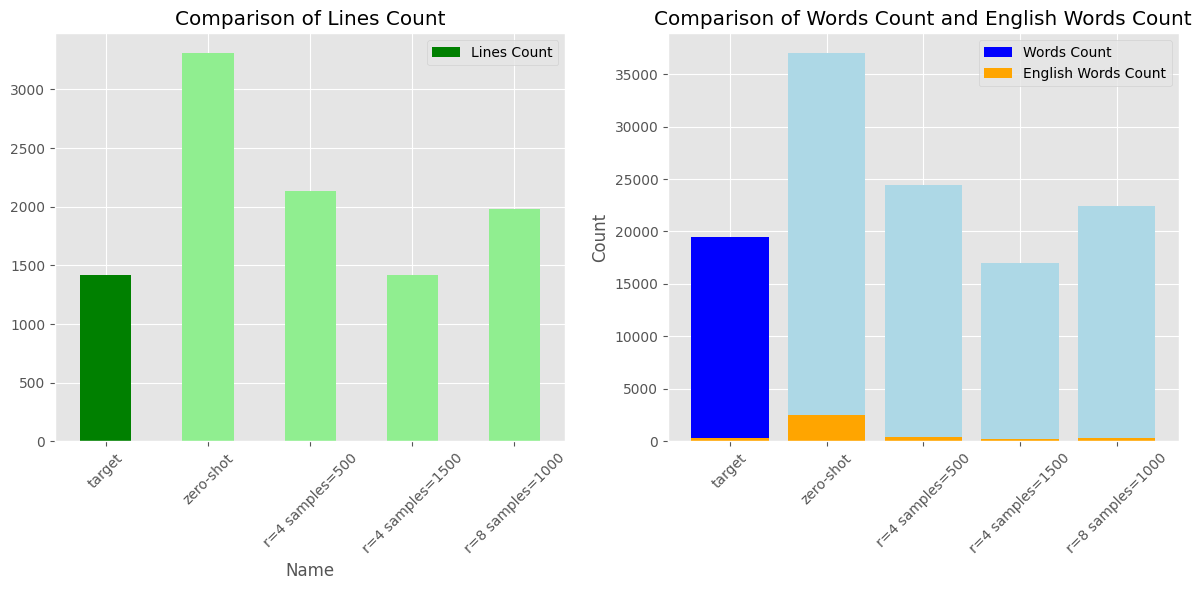

In [4]:
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors1 = ['green' if name == 'target' else 'lightgreen' for name in df['Name']]
df.plot(kind='bar', x='Name', y='Lines', label='Lines Count', color=colors1, ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Comparison of Lines Count')

plt.subplot(1, 2, 2)
colors2 = ['blue' if name == 'target' else 'lightblue' for name in df['Name']]
colors3 = ['orange' if name == 'target' else 'orange' for name in df['Name']]
plt.bar(df['Name'], df['Words'], label='Words Count', color=colors2)
plt.bar(df['Name'], df['English Words'], label='English Words Count', color=colors3)
plt.xticks(rotation=45)
plt.title('Comparison of Words Count and English Words Count')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

### Calculate non-english words similarity

In [5]:
ground_truth = df.loc[df['Name'] == 'target', 'English Words %'].values[0]
percentages = df.loc[df['Name'] != 'target', 'English Words %'].values
percentages_differences_scaled = abs(ground_truth - percentages) * 10
content_similarity_score_scaled = abs(100 - percentages_differences_scaled)

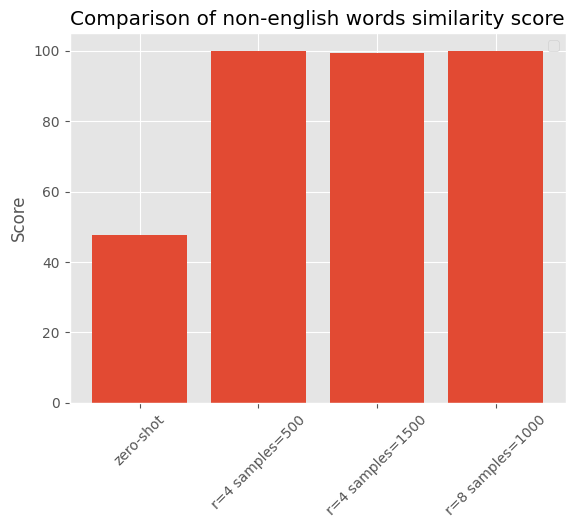

In [6]:
plt.bar(names[1:], content_similarity_score_scaled)
plt.xticks( rotation=45)
plt.title('Comparison of non-english words similarity score')
plt.ylabel('Score')
plt.legend()

plt.show()

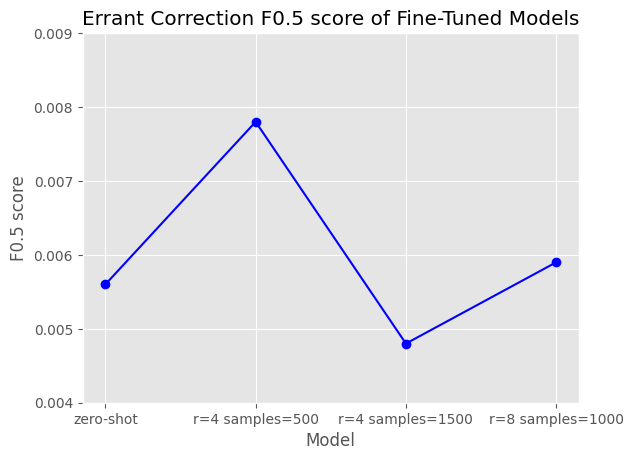

In [7]:
fine_tuned_models_df = df[df['Name'] != 'target']

plt.plot(fine_tuned_models_df['Name'], fine_tuned_models_df['Errant Correction'],marker='o',color='blue')
plt.title('Errant Correction F0.5 score of Fine-Tuned Models')
plt.xlabel('Model')
plt.ylabel('F0.5 score')
plt.ylim(0.004, 0.009)
plt.grid(True)
plt.show()

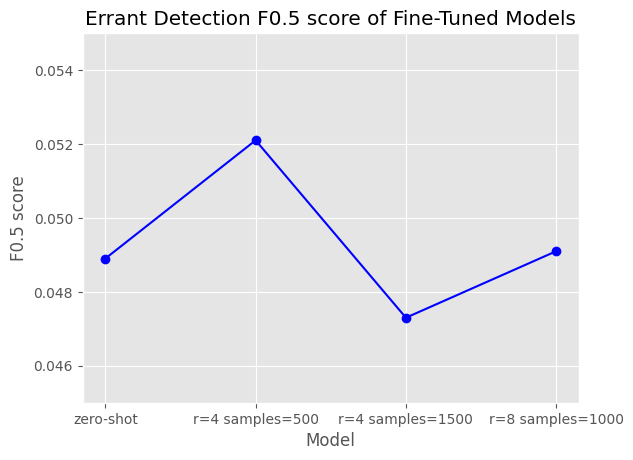

In [8]:
plt.plot(fine_tuned_models_df['Name'], fine_tuned_models_df['Errant Detection'],marker='o',color='blue')
plt.title('Errant Detection F0.5 score of Fine-Tuned Models')
plt.xlabel('Model')
plt.ylabel('F0.5 score')
plt.ylim(0.045, 0.055)
plt.grid(True)
plt.show()